# Social Network Analysis
So here we are, back yet, again! This time, we'll start exploring a network analysis. A network analysis enables us to find connections or communities within specific user networks. What we then can do with this, is go on and make recommendations about who to follow or what to watch out for that you aren't already within your current network. In the gaming sense, it could also be used to recommend teams for various tournaments **based solely on who you know and who you know knows**.

Just like with the other notebooks, if you who want the quick notes on our findings, Find them below. Enjoy!

## Outcomes
The outcome of this notebook is to get a teaser of the power and capability of network graphs with our follower-followee dataset. We took an example user and visualized their network and the various communities or groups within that users network. More or so a "network of networks". Deeper analysis could be made to make recommendations on who to follow based on who is in their network. Additionally, you could take the influencers of each network and incentive them to host events that result in engagement from everyone within that network they're connected to.


## Previous Findings
If you skipped the previous notebook, no worries, here's our findings from that.

- February 2020 and August 2021 have huge spikes in follower activity nodding at some sort of event, campaign, or influencer arriving on the platform.
- With the huge spikes in February 2020 and August 2021, it's hard to get a view on what "consistent" follower engagement looks like month to month.
- With only one full year of data (2020) it's safe to say there is a lot of opportunity to shape follower activity in the future (could reward users for reaching n-number of followers or for supporting n-number of users).
- While there are some notable users with substantial followers, there is still over 1/3rd of the platform not engaging as both, a follower and followee.
- Over 3/4th of users following others on the platform have 0 followers themselves, indicating uninteresting profiles or a lack of engagement with the platform and who they've been following.
- 50% of those being followed have 2 or less followers, whereas of the top 25% users being followed, 75% of them have 29 followers or less. Nodding that folks go to the platform to follow the same n-number accounts, only wanting to engage with them versus other users.

Let's load in some useful functions and packages.

In [1]:
# accessing utils module
import sys
sys.path.append('../utils')

# needed for loading data:
import pandas as pd

# some problem-specific helper functions:
from utils import get_path, get_followers
from visualize import plot_network_graph

# to visualize our network
import networkx as nx

# for our community analysis
from community import community_louvain

## The follower event database

Our dataset consists of over 609,080 follower-followee events:

- **follower** - The id of the person that initiated the follow
- **followee** - The id of the person being followed

Run the code below to load our data into our notebook!

In [2]:
print("Location of data files:", get_path('processed'))
print("Location of anonymized followers data:", get_path('processed/followers_deduped.csv'))
print("Loading...")
df = pd.read_csv(get_path('processed/followers_deduped.csv'), index_col=0)
print("...Done loading")
print("Displaying the first 5 rows...")
df.head(5)

Location of data files: /Users/matthewquinn/dev/eFuse-sample/data/processed
Location of anonymized followers data: /Users/matthewquinn/dev/eFuse-sample/data/processed/followers_deduped.csv
Loading...
...Done loading
Displaying the first 5 rows...


,follower,followee
0,782bc0ce5ffe00c95bbc52f72fc654a2,e83a54eefe2ff5daf80a66505f9472a4
1,e83a54eefe2ff5daf80a66505f9472a4,782bc0ce5ffe00c95bbc52f72fc654a2
2,782bc0ce5ffe00c95bbc52f72fc654a2,4627a06c99dde3d167166eaab32e947d
3,782bc0ce5ffe00c95bbc52f72fc654a2,49b76015d44936cb2c2184fc805e88a6
4,782bc0ce5ffe00c95bbc52f72fc654a2,1e66c9b143e9ee9155d0dcaa8d5997b0


## Setting up our network
Networks consist of nodes and edges. In our scenario, nodes will represent the user and edges are the links from one user to another. For our network, we'll need to identify a source and target group. We already have that in our data, but let's rename some columns to make this more apparent.

In [3]:
df.rename(columns={"follower":"target", "followee":"source"},inplace=True)
display(df.head())

,target,source
0,782bc0ce5ffe00c95bbc52f72fc654a2,e83a54eefe2ff5daf80a66505f9472a4
1,e83a54eefe2ff5daf80a66505f9472a4,782bc0ce5ffe00c95bbc52f72fc654a2
2,782bc0ce5ffe00c95bbc52f72fc654a2,4627a06c99dde3d167166eaab32e947d
3,782bc0ce5ffe00c95bbc52f72fc654a2,49b76015d44936cb2c2184fc805e88a6
4,782bc0ce5ffe00c95bbc52f72fc654a2,1e66c9b143e9ee9155d0dcaa8d5997b0


Great! To clarify the above:

- **target** - follows (follower) the source (followee)
- **source** - the users (followee) that recieved the follow

**Getting the source's followers** In order to analyze a network, we'll to select a user and start there.

**For the purpose of illustration, for the remaining of this notebook, I'll be using a random user to demonstrate this analysis!**

In [4]:
example_user = "fffaf5721a5e42c72b2ed8b879edbe3a"

The above user will serve as our test account, great!

The next step is to gather all of the users following our source or `example_user`.

In [5]:
example_network = pd.DataFrame(columns=["source","target"])
example_network["target"] = get_followers(df, example_user)
example_network["source"] = example_user
print("\nTaking a look at our users network!\n")
example_network


Taking a look at our users network!



,source,target
0,fffaf5721a5e42c72b2ed8b879edbe3a,d7cc098a5813710adc54799b71dc686a
1,fffaf5721a5e42c72b2ed8b879edbe3a,4e48ada1cb351bbecdc650842241faff
2,fffaf5721a5e42c72b2ed8b879edbe3a,6bc2e70ea4eb52748f58d38a1eac6130
3,fffaf5721a5e42c72b2ed8b879edbe3a,0f99bbbf354d2e11fce07fa26f1009d7
4,fffaf5721a5e42c72b2ed8b879edbe3a,18270c740e3887fd59efd539bf9df0f6
5,fffaf5721a5e42c72b2ed8b879edbe3a,098574931143f518897c57f89e015070
6,fffaf5721a5e42c72b2ed8b879edbe3a,c5c001468473f0ee648ac4d7b7fe3b82
7,fffaf5721a5e42c72b2ed8b879edbe3a,5e1ab920b988fb71f5ae532db2fc449e


This specific user has 8 followers in their network.

Let's go ahead and visualize this.

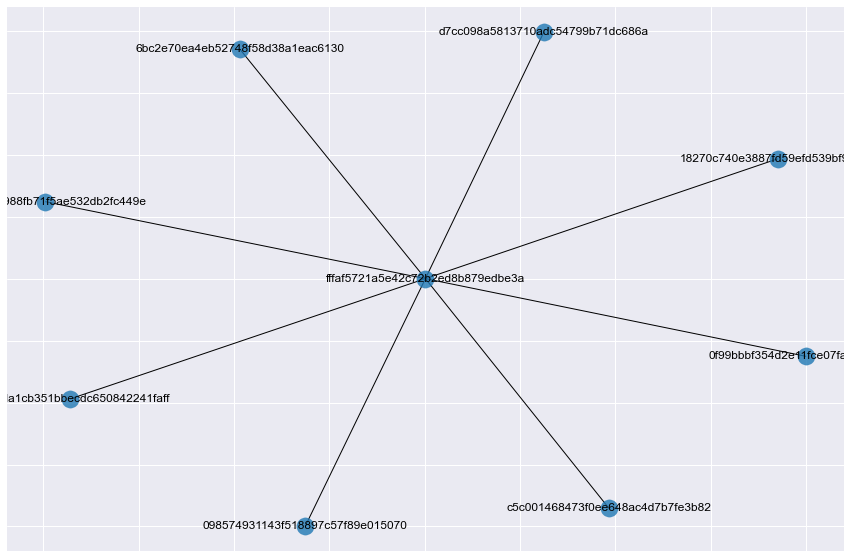

In [6]:
graph = nx.from_pandas_edgelist(example_network, "source", "target")
plot_network_graph(graph)

Not bad, not bad! The chart is somewhat ugly, but there are a lot of packages and libraries out there to prettify this up. Due to time constraints, I won't worry about the visual appeal here too much.

**Explaining the Visuals** At the center of our network is our user `fffaf5721a5e42c72b2ed8b879edbe3a` and the lines connecting to our user are represented as `edges`. Think of `edges` as connectors. What are they connecting too? Great question! The blue dots at the end of those `edges` are called `nodes`. `nodes` represent the other users in our network.

While the above shows us the immediate network for our user, we can take this further by expanding this. We do this by pulling in the network of the folks directly following our user.

## Building Out Our Network

As mentioned above, we want to pull in the network of those immediately following us. Let's write some code to do that!

In [7]:
user_list = list(example_network.target)
for user in user_list: 
    follower_list = get_followers(df, user)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list
    temp['source'] = user
    example_network = example_network.append(temp)

print("10 random users from our network of networks")
display(example_network.sample(10))
graph = nx.from_pandas_edgelist(example_network, 'source', 'target')
print("Number of nodes, or connections, in our network!", graph.number_of_nodes(), sep="\n ===> ")

10 random users from our network of networks


,source,target
89,5e1ab920b988fb71f5ae532db2fc449e,f3a07f1c636b3f2caab58ff86f5f528c
711,5e1ab920b988fb71f5ae532db2fc449e,93dd9d38e858087fdd243486dc42109e
1831,5e1ab920b988fb71f5ae532db2fc449e,d8c8d60d0430cf0621a4e316a279a043
1383,5e1ab920b988fb71f5ae532db2fc449e,37e4b759e9102e9adf583d9b7120c638
461,5e1ab920b988fb71f5ae532db2fc449e,974dfdc483c156ec4205ea67445bb052
4,4e48ada1cb351bbecdc650842241faff,fffaf5721a5e42c72b2ed8b879edbe3a
731,5e1ab920b988fb71f5ae532db2fc449e,2c29e38fa8439100e2360518c7f18046
1415,5e1ab920b988fb71f5ae532db2fc449e,01042b7fdd477d0dbd4de0c73f0067fb
127,c5c001468473f0ee648ac4d7b7fe3b82,427bbdab3c238a9b428cf3568eb8d2c4
1422,5e1ab920b988fb71f5ae532db2fc449e,30affc9a3593997178395ddcac6bbcd8


Number of nodes, or connections, in our network!
 ===> 2627


Based on the folks that follow the accounts that follow us, our network is 2,627 strong! Now that we have this, we can take a look at the most influential users in our network via a measurement of centrality known as Degree Centrality.

**Degree Centrality** is a measure of influence in a social network that scores a users importance based on how many `edges` are held by each `node`.

In [8]:
print("\nTop 5 influencers in our network (our followers) based on their network:")
pd.DataFrame(sorted(
    graph.degree, key=lambda x: x[1], reverse=True
), columns=["names","degree"]).head()


Top 5 influencers in our network (our followers) based on their network:


,names,degree
0,5e1ab920b988fb71f5ae532db2fc449e,2214
1,c5c001468473f0ee648ac4d7b7fe3b82,316
2,098574931143f518897c57f89e015070,201
3,d7cc098a5813710adc54799b71dc686a,46
4,0f99bbbf354d2e11fce07fa26f1009d7,36


Based on the above, the most influencial follower in our example user's network is `5e1ab920b988fb71f5ae532db2fc449e` with a network of 2,214!

Let's go ahead and start our communnity analysis, based on groups and degree centrality. But before that, let's go ahead and trim our network.

**Removing network with less than nth degrees** To speed things up, and to prevent a huge network graph, let's go ahead and remove nodes from our graph that have less than 2 total nodes in their network. Let's make sure we continue to include our example user as the connector of this network!

In [9]:
remove = [node for node, degree in dict(graph.degree()).items() if degree < 4 and node != example_user]
graph.remove_nodes_from(remove)

There, our network is trimmed! Next, let's examine our community network using a Louvain Heuristics.

**Louvain Heuristics** is a technique that allows us to split our network into groups of the same or similar nodes or connections.

Let's continue our example and set this up.

In [10]:
partition = community_louvain.best_partition(graph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index().rename(columns={"index": "names", 0: "group"})
print("Number of groups in our network:", partition1.group.nunique(), sep="\n ====> ")

Number of groups in our network:
 ====> 3


As mentioned above, we have 3 different groups identified in our network. So use this to say, within our network, there are three different networks that our user is connected too.

Great! Now that we have our groups, let's re-running our code to generate the degree centrality since we've trimmed down our nodes.

In [11]:
degree_centrality = pd.DataFrame(sorted(
    graph.degree, key=lambda x: x[1], reverse=True
), columns=["names","degree"])
display(degree_centrality.head())

,names,degree
0,c5c001468473f0ee648ac4d7b7fe3b82,18
1,5e1ab920b988fb71f5ae532db2fc449e,18
2,098574931143f518897c57f89e015070,15
3,d7cc098a5813710adc54799b71dc686a,10
4,6bc2e70ea4eb52748f58d38a1eac6130,9


Now let's combined our groups with our degree centrality dataframe.

In [12]:
combined = pd.merge(degree_centrality, partition1, how='left', left_on="names", right_on="names")
combined.head()

,names,degree,group
0,c5c001468473f0ee648ac4d7b7fe3b82,18,0
1,5e1ab920b988fb71f5ae532db2fc449e,18,2
2,098574931143f518897c57f89e015070,15,1
3,d7cc098a5813710adc54799b71dc686a,10,1
4,6bc2e70ea4eb52748f58d38a1eac6130,9,0


Sweet! Now that this is done, we can go ahead and visualize what this looks like!

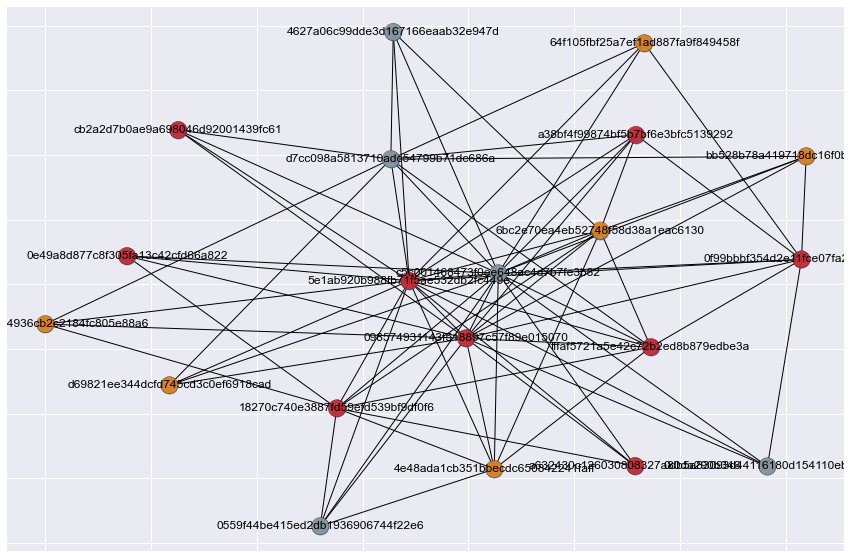

In [13]:
plot_network_graph(graph, plot_groups=combined)

Yuck! This is messy. But again, there are plenty of other tools out there to make network graphs a lot cleaner and easier to compute, but the learning curve for those can be steep. So bare with me!

**Explaining the Visualization** It's tough to tell, but at the center of our network lies our user. Also notice the various colors for each node (gray, orange, red). These represent the 3 different groups identified earlier. What you can do with these is you can make recommendations on who users could follow based on who in their network follows who.

Another thing you could do with something like this is to size each node based on the degree, indicating the most influential members in your network and so forth.

## Wrapping Up
Great, we've made it to the end! To recap, we completed an example network analysis and provided some recommendations on how to utilize the users network to stimulate follower activity. Outside of this very simple network graph, there is a lot more that can be done in this arena, but it takes a lot of computing power and a lot of time to zip through every users network. However, this is a solid example to get the juices flowing. Until next time!